In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as dataset
import torchvision.transforms as transforms

# Solution 2 :

## Importing the data and splitting it in training set, validation set and testing set.

In [2]:
# Importing the data using sklearn datasets
data_Set = datasets.fetch_openml('mnist_784')

In [3]:
# Separately taking the value of the data and the target/label
X = data_Set.data
y = data_Set.target
X_Original = X[:60000]
y_Original = y[:60000]

In [4]:
y_Original = y_Original.astype(np.int64)

In [ ]:
# For checking the type and size of the variables
print(type(X_Original))
print(type(y_Original))
print(X_Original.shape)
print(y_Original.shape)

In [5]:
# We want to split the data in the ratio of 70:15:15 for training set, validation set and testing set respectively.
# We first split the data in training set and remaining set.
X_Train, X_Remain, y_Train, y_Remain = train_test_split(X_Original, y_Original, train_size = 0.7)

In [ ]:
# For checking the shape of the training set and remaining set after splitting the original dataset.
print(X_Train.shape)
print(y_Train.shape)
print(X_Remain.shape)
print(y_Remain.shape)

In [6]:
# Now, we split the remaining set into equal halves to get 15% percent each in the validation set and the testing set.
X_Valid, X_Test, y_Valid, y_Test = train_test_split(X_Remain, y_Remain, test_size = 0.5)

In [ ]:
# For checking the shape of the validation set and testing set after splitting the original dataset.
print(X_Valid.shape)
print(y_Valid.shape)
print(X_Test.shape)
print(y_Test.shape)

In [ ]:
# For verifying the shape of all the datasets finally
print(X_Train.shape)
print(y_Train.shape)
print(X_Valid.shape)
print(y_Valid.shape)
print(X_Test.shape)
print(y_Test.shape)

## Defining all the functions for 
#### 1. Initializing the parameters
#### 2. Activation Function and it's derivative
#### 3. Forward Propogation
#### 4. Backward Propogation
#### 5. Updating the parameters
#### 6. Accuracy and Loss
#### 7. Predictions

In [7]:
# For initializing all the parameters
def initialize_Parameters():
    w1 = np.random.randn(30, 784) * 0.01
    b1 = np.random.randn(30, 1) * 0.01
    # b1 = np.zeros([30, 1]) * 0.01
    w2 = np.random.randn(10, 30) * 0.01
    b2 = np.random.randn(10, 1) * 0.01
    # b2 = np.zeros([10,1]) * 0.01
    return w1, b1, w2, b2

# Sigmoid Activation Function
def sigmoid_Activation_Function(x):
    return 1 / (1 + np.exp(-x))

# For calculating the final output/prediction on the given input and features using forward propogation
def forward_Propagation(x, w1, b1, w2, b2):
    z1 = np.dot(w1, x.T) + b1
    a1 = sigmoid_Activation_Function(z1)
    z2 = np.dot(w2, a1) + b2
    a2 = sigmoid_Activation_Function(z2)
    return z1, a1, z2, a2

# For doing one hot encoding on Y
def one_Hot_Encoding(y):
    one_Hot_Y = np.zeros((y.size, 10))
    one_Hot_Y[np.arange(y.size), y] = 1
    one_Hot_Y = one_Hot_Y.T
    return one_Hot_Y

# Derivative of Sigmoid Activation Function
def sigmoid_Derivative(x):
    return np.multiply(sigmoid_Activation_Function(x), (1 - sigmoid_Activation_Function(x)))

# For traversing backwards and calculating the gradients along the way
def backward_Propagation(x, y, w1, z1, a1, w2, z2, a2, batch_Size):
    one_Hot_Y = one_Hot_Encoding(y)
    delta_2 = (1 / batch_Size) * (a2 - one_Hot_Y) * sigmoid_Derivative(z2)
    dw2 = np.dot(delta_2, a1.T)
    db2 = np.sum(delta_2, axis = 1).reshape(10,-1)
    delta_1 = np.dot(w2.T, delta_2) * sigmoid_Derivative(z1)
    dw1 = (1 / batch_Size) * np.dot(delta_1, x)
    db1 = (1 / batch_Size) * np.sum(delta_1, axis = 1).reshape(30,-1)
    return dw1, db1, dw2, db2

# For updating the values of parameters with the given learning rate and the gradients calculated
def update_Parameters(alpha, w1, dw1, b1, db1, w2, dw2, b2, db2):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    return w1, b1, w2, b2

# For getting the predictions
def get_Predictions(a2):
    return np.argmax(a2, 1)

# For getting the accuracy
def get_Accuracy(predictions, y):
    return (np.sum(predictions == y) / y.size) * 100

# For calculating the loss
def mse_Loss(a2, y):
    loss = (a2 - y) * (a2 - y)
    loss = (1 / y.size) * np.sum(loss)
    return loss

# For making the predictions on Validation and Testing Data
def make_Predictions(x, y, w1, b1, w2, b2):
    _, _, _, a2 = forward_Propagation(x, w1, b1, w2, b2)
    predictions = get_Predictions(a2.T)
    accuracy = get_Accuracy(predictions, y)
    loss = mse_Loss(a2.T, one_Hot_Encoding(y).T)
    return accuracy, loss


In [23]:
# Training the model using forward propogation, backward propogation and updating the parameters.
# Plotting the graph for the calculated accuracies
def stochastic_Gradient_Descent(x, y, alpha, epochs, batch_Size):
    w1, b1, w2, b2 = initialize_Parameters()
    batches = len(x)//batch_Size
    train_Accuracy = []
    valid_Accuracy = []
    for i in range(epochs):
        start_Index = 0
        a2_Final = []
        for j in range(batches):
            end_Index = start_Index + batch_Size
            z1, a1, z2, a2 = forward_Propagation(x[start_Index:end_Index], w1, b1, w2, b2)
            a2_Temp = a2.T
            for k in range(batch_Size):
                a2_Final.append(list(a2_Temp[k]))
            dw1, db1, dw2, db2 = backward_Propagation(x[start_Index:end_Index], y[start_Index:end_Index], w1, z1, a1, w2, z2, a2, batch_Size)
            w1, b1, w2, b2 = update_Parameters(alpha, w1, dw1, b1, db1, w2, dw2, b2, db2)
            start_Index = end_Index
        epoch_Train_Accuracy = get_Accuracy(get_Predictions(a2_Final), y)
        epoch_Train_Loss = mse_Loss(a2_Final, one_Hot_Encoding(y).T)
        epoch_Valid_Accuracy, epoch_Valid_Loss = make_Predictions(X_Valid, y_Valid, w1, b1, w2, b2)
        train_Accuracy.append(epoch_Train_Accuracy)
        valid_Accuracy.append(epoch_Valid_Accuracy)
        if i % 10 == 0:
            print("Iteration :", i)
            print("Training Set Accuracy :", epoch_Train_Accuracy)
            print("Training Set Loss :", epoch_Train_Loss)
            print("Validation Set Accuracy :", epoch_Valid_Accuracy)
            print("Vaidation Set Loss :", epoch_Valid_Loss)
    final_Test_Accuracy, final_Test_Loss = make_Predictions(X_Test, y_Test, w1, b1, w2, b2)
    print("Testing Set Accuracy :", final_Test_Accuracy)
    print("Testing Set Loss :", final_Test_Loss)
    # For plotting the graph for accuracies
    plt.plot(train_Accuracy, label = "Training Accuracy")
    plt.plot(valid_Accuracy, label = "Validation Accuracy")
    plt.legend()
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Vs Number of Epochs")
    return

Iteration : 0
Training Set Accuracy : 13.695238095238096
Training Set Loss : 0.09274633349188757
Validation Set Accuracy : 16.433333333333334
Vaidation Set Loss : 0.08864847244519347
Iteration : 10
Training Set Accuracy : 90.40714285714286
Training Set Loss : 0.022081808563418796
Validation Set Accuracy : 89.62222222222222
Vaidation Set Loss : 0.022388438536893224
Iteration : 20
Training Set Accuracy : 91.99761904761905
Training Set Loss : 0.015729244822864172
Validation Set Accuracy : 90.54444444444445
Vaidation Set Loss : 0.017149767057611835
Iteration : 30
Training Set Accuracy : 92.62619047619047
Training Set Loss : 0.013832519035097012
Validation Set Accuracy : 90.75555555555556
Vaidation Set Loss : 0.01582594425094082
Iteration : 40
Training Set Accuracy : 92.98095238095239
Training Set Loss : 0.012673288368327406
Validation Set Accuracy : 91.05555555555556
Vaidation Set Loss : 0.015024001958668211
Iteration : 50
Training Set Accuracy : 93.31904761904762
Training Set Loss : 0.012

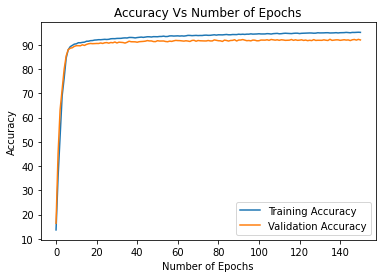

In [28]:
# Calling the function
stochastic_Gradient_Descent(X_Train, y_Train, 0.005, 151, 8)

# Solution 3 :

## Importing the data and splitting it in training set, validation set and testing set.

In [10]:
# Importing the dataset using torchvision datasets
input_Data_PT = dataset.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())

In [11]:
# For checking the length of the dataset
print(len(input_Data_PT))

60000


In [12]:
# For splitting the data in the ratio of 70:15:15 for training set, validation set and testing set respectively.
train_Data_Length = int(0.70 * len(input_Data_PT))
valid_Data_Length = int(0.15 * len(input_Data_PT))
test_Data_Length = int(0.15 * len(input_Data_PT))

In [13]:
# For checking the length after calculation
print(train_Data_Length)
print(valid_Data_Length)
print(test_Data_Length)

42000
9000
9000


In [14]:
# For splitting the data in the ratio of 70:15:15 for training set, validation set and testing set respectively.
train_Data, valid_Data, test_Data = data.random_split(input_Data_PT, [train_Data_Length, valid_Data_Length, test_Data_Length], generator = torch.Generator().manual_seed(7))

In [39]:
# For loading the data in DataLoader format
train_Data_Loader = data.DataLoader(train_Data, batch_size = 8, shuffle = True)
train_Data_Loader_Full = data.DataLoader(train_Data, batch_size = len(train_Data), shuffle = True)
valid_Data_Loader = data.DataLoader(valid_Data, batch_size = len(valid_Data), shuffle = True)
test_Data_Loader = data.DataLoader(test_Data, batch_size = len(test_Data), shuffle = True)

## Defining the Neural Network

In [40]:
# Defining the function, loss, optimizer and epochs
neural_Network_PT = torch.nn.Sequential(nn.Linear(784, 30), nn.Sigmoid(), nn.Linear(30, 10), nn.Sigmoid())
loss_PT = nn.MSELoss()
optimization_PT = torch.optim.SGD(neural_Network_PT.parameters(), lr = 0.005)
epochs_PT = 31

In [41]:
# For calculating the accuracy and loss on validation set and testing set
def get_Accuracy_And_Loss(data_Loader):
    for _, dataset in enumerate(data_Loader):
        X, y = dataset
        y_hat = neural_Network_PT(X.view(-1, 784))
        accuracy = 100 * (torch.argmax(y_hat, dim = 1) == y).sum() / len(X)
        loss = loss_PT(y_hat, F.one_hot(y, num_classes = 10).float())
    return accuracy, loss

## Training the Neural Network

In [42]:
# For training the model and plotiing the accuracies
def stochastic_Gradient_Descent_PT(epochs_PT):
    train_Accuracy_PT = []
    valid_Accuracy_PT = []
    for i in range(epochs_PT):
        for _, dataset in enumerate(train_Data_Loader):
            X_Train_PT, y_Train_PT = dataset
            y_hat = neural_Network_PT(X_Train_PT.view(-1, 784))
            train_Loss = loss_PT(y_hat, F.one_hot(y_Train_PT, num_classes = 10).float())
            optimization_PT.zero_grad()
            train_Loss.backward()
            optimization_PT.step()
        epoch_Train_Accuracy_PT, epoch_Train_Loss_PT = get_Accuracy_And_Loss(train_Data_Loader_Full)
        epoch_Valid_Accuracy_PT, epoch_Valid_Loss_PT = get_Accuracy_And_Loss(valid_Data_Loader)
        train_Accuracy_PT.append(epoch_Train_Accuracy_PT)
        valid_Accuracy_PT.append(epoch_Valid_Accuracy_PT)
        if i % 10 == 0:
                print("Iteration :", i)
                print("Training Set Accuracy :", epoch_Train_Accuracy_PT)
                print("Training Set Loss :", epoch_Train_Loss_PT)
                print("Validation Set Accuracy :", epoch_Valid_Accuracy_PT)
                print("Vaidation Set Loss :", epoch_Valid_Loss_PT)
    final_Test_Accuracy_PT, final_Test_Loss_PT = get_Accuracy_And_Loss(test_Data_Loader)
    print("Testing Set Accuracy :", final_Test_Accuracy_PT)
    print("Testing Set Loss :", final_Test_Loss_PT)
    # For plotting the graph for accuracies
    plt.plot(train_Accuracy_PT, label = "Training Accuracy")
    plt.plot(valid_Accuracy_PT, label = "Validation Accuracy")
    plt.legend()
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Vs Number of Epochs")
    return
    

Iteration : 0
Training Set Accuracy : tensor(20.2833)
Training Set Loss : tensor(0.0925, grad_fn=<MseLossBackward0>)
Validation Set Accuracy : tensor(19.9000)
Vaidation Set Loss : tensor(0.0925, grad_fn=<MseLossBackward0>)
Iteration : 10
Training Set Accuracy : tensor(32.6595)
Training Set Loss : tensor(0.0871, grad_fn=<MseLossBackward0>)
Validation Set Accuracy : tensor(32.7778)
Vaidation Set Loss : tensor(0.0871, grad_fn=<MseLossBackward0>)
Iteration : 20
Training Set Accuracy : tensor(38.6310)
Training Set Loss : tensor(0.0785, grad_fn=<MseLossBackward0>)
Validation Set Accuracy : tensor(38.7333)
Vaidation Set Loss : tensor(0.0785, grad_fn=<MseLossBackward0>)
Iteration : 30
Training Set Accuracy : tensor(60.0762)
Training Set Loss : tensor(0.0654, grad_fn=<MseLossBackward0>)
Validation Set Accuracy : tensor(60.3111)
Vaidation Set Loss : tensor(0.0655, grad_fn=<MseLossBackward0>)
Testing Set Accuracy : tensor(60.8778)
Testing Set Loss : tensor(0.0650, grad_fn=<MseLossBackward0>)


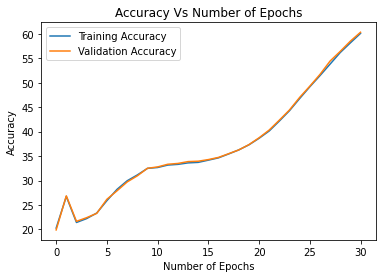

In [43]:
# Calling the function
stochastic_Gradient_Descent_PT(31)

### From the above two results we can see that we get the different accuracies for a batchsize of 8 and 31 epochs using implementation from scratch and using pytorch.
#### *Note : It gets more similiar for smaller batchsize and more epochs but it was crashing my laptop.

# Solution 4 :

## Improving the training process 

In [44]:
# Changing the loss function and optimizer to improve the neural network
neural_Network_PT = torch.nn.Sequential(nn.Linear(784, 30), nn.Sigmoid(), nn.Linear(30, 10), nn.Sigmoid())
loss_PT = nn.CrossEntropyLoss()
optimization_PT = torch.optim.Adam(neural_Network_PT.parameters(), lr = 0.005)
epochs_PT = 31

Iteration : 0
Training Set Accuracy : tensor(92.8286)
Training Set Loss : tensor(1.5337, grad_fn=<DivBackward1>)
Validation Set Accuracy : tensor(92.1556)
Vaidation Set Loss : tensor(1.5420, grad_fn=<DivBackward1>)
Iteration : 10
Training Set Accuracy : tensor(96.2333)
Training Set Loss : tensor(1.4958, grad_fn=<DivBackward1>)
Validation Set Accuracy : tensor(93.7889)
Vaidation Set Loss : tensor(1.5183, grad_fn=<DivBackward1>)
Iteration : 20
Training Set Accuracy : tensor(96.5929)
Training Set Loss : tensor(1.4910, grad_fn=<DivBackward1>)
Validation Set Accuracy : tensor(94.2444)
Vaidation Set Loss : tensor(1.5165, grad_fn=<DivBackward1>)
Iteration : 30
Training Set Accuracy : tensor(96.9143)
Training Set Loss : tensor(1.4870, grad_fn=<DivBackward1>)
Validation Set Accuracy : tensor(94.2333)
Vaidation Set Loss : tensor(1.5161, grad_fn=<DivBackward1>)
Testing Set Accuracy : tensor(94.8000)
Testing Set Loss : tensor(1.5093, grad_fn=<DivBackward1>)


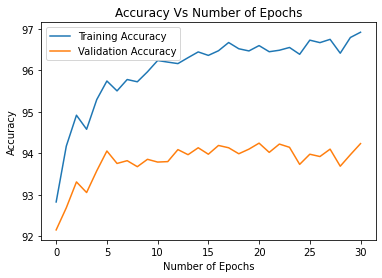

In [45]:
#Calling the function
stochastic_Gradient_Descent_PT(31)